## Building the graph

### Clipping: Considerating only Python mentions

After getting and parsing the data, we need to understand and create metrics that could lead us to our hypothesis and it's impacts.

In [85]:
from netpixi.integration.gt import Graph
import pandas as pd
import numpy as np

g = Graph(directed=False)

In [86]:
data = pd.read_csv("../data/colaboration_comments.csv")

In [87]:
# Add the source repositories (usually belonging to organizations where users collaborate)
data['source'] = list(map(lambda x : x.split("https://github.com/")[-1].split('/')[0],data['URL']))

In [88]:
#Only Python mentions
data = data[data['BODY'].notna() & data['BODY'].str.lower().str.contains('python|py')]

In [89]:
# Drop columns which we won't use
data = data.drop(['COMMIT_ID','COMMENT_ID','URL'],axis=1)

In [90]:
#First view of data
data

,AUTHOR,CREATED_AT,BODY,source
19,CarlosX,2015-01-01T00:12:02Z,Happy new year! xD,Arctium
23,foosel,2015-01-01T00:13:42Z,The new app api keys are documented [here](htt...,alexrj
50,j2sol,2015-01-01T00:26:09Z,Looks like copypasta. a2dissite_binary in the ...,blueboxgroup
171,arrmo,2015-01-01T01:12:06Z,"Hi,\r\n\r\nFor some reason I just got notified...",snazy2000
208,ldo,2015-01-01T01:26:19Z,Unnecessary. Callers already check `PyErr_Occu...,reubenhwk
...,...,...,...,...
634935,kuba,2015-02-28T07:31:52Z,For the time being I follow the policy that on...,letsencrypt
635048,DoumanAsh,2015-02-28T08:24:43Z,Maybe it would be more right just to store con...,pmzqla
635058,ahmedre,2015-02-28T08:28:40Z,this is possibly a hack - open to suggestions ...,square
635180,ace2nutzer,2015-02-28T09:06:51Z,thank u....\r\n\r\nroot@codinap:/ # cat /proc/...,ace2nutzer


In [91]:
#Looking to the total contribuitions for the users in the source repositories
total_contributions = data.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
total_contributions

AUTHOR
jirikuncar         1385
mister-roboto       484
biocad-teamcity     135
kaplun              126
linthubot           100
                   ... 
kenzierocks           1
cemak                 1
kentonv               1
kenshinx              1
007lva                1
Name: source, Length: 7627, dtype: int64

In [92]:
# As we can see there are many contribuitors who participated much less than the average, we're going to use this to filter 
# the data: contribuitors who has less contributions than the average will not be considered for the network
total_contributions.describe()

count    7627.000000
mean        2.679428
std        17.398302
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max      1385.000000
Name: source, dtype: float64

In [93]:
#Cleaning the data as explaneid above
contribuitors = data.groupby(['source']).count()['AUTHOR'].sort_values(ascending=False)
contribuitors_mean = contribuitors.mean()
repos_edge = contribuitors[contribuitors>contribuitors_mean]
repos_edge.index

Index(['jirikuncar', 'plone', 'edx', 'mozilla', 'apache', 'hpcugent',
       'scikit-learn', 'bartvm', 'django', 'Stanford-Online',
       ...
       'OpenELEC', 'ilv', 'the-tcpdump-group', 'kangaroo', 'gauravmittal1995',
       'bitcoin', 'bloomberg', 'squerb', 'theanh90', 'theatlantic'],
      dtype='object', name='source', length=716)

In [94]:
#filtering
data_clean = data[data['source'].isin(repos_edge.index)]

In [95]:
data_clean

,AUTHOR,CREATED_AT,BODY,source
50,j2sol,2015-01-01T00:26:09Z,Looks like copypasta. a2dissite_binary in the ...,blueboxgroup
260,berkerpeksag,2015-01-01T01:43:01Z,I'd start with `$ PYTHONPATH=. python ...` here.,spotify
301,pbrunet,2015-01-01T10:02:12Z,I think you should make it recursive once the ...,serge-sans-paille
323,CyberShadow,2015-01-01T10:14:42Z,I wasn't thinking of C++ iterators when I chos...,D-Programming-Language
463,Minecrell,2015-01-01T11:42:11Z,"This has to be an immutable map, you can eithe...",SpongePowered
...,...,...,...,...
634853,konklone,2015-02-28T06:53:59Z,Django does have an idea of what environment i...,18F
634880,NTaylorMullen,2015-02-28T07:04:39Z,"Hmmm, should our `CopyTo`s be clearing the con...",aspnet
634882,NTaylorMullen,2015-02-28T07:05:28Z,Depending on the result of this conversation: ...,aspnet
634935,kuba,2015-02-28T07:31:52Z,For the time being I follow the policy that on...,letsencrypt


We already have the filter to build the network with a good context to define an edge between two collaborators: 

**There are an edge between them if they have at least one collaboration in a relevant source**

Even so, there many developers who collaborate very little, and we need to adjust our data to maintain only developers with a appropriate average frequency in mass of data to avoid any bias due collators with less interactions than the average of collaborations.

In [96]:
#Contributions to define an edge
edge_contrib = data_clean.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
#Average contributions
average_contrib =edge_contrib.mean()
#Filtering
above_average_contrib = edge_contrib[edge_contrib>average_contrib]
data_clean = data_clean[data_clean['AUTHOR'].isin(above_average_contrib.index)]
authors = data_clean.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
data_clean

,AUTHOR,CREATED_AT,BODY,source
50,j2sol,2015-01-01T00:26:09Z,Looks like copypasta. a2dissite_binary in the ...,blueboxgroup
260,berkerpeksag,2015-01-01T01:43:01Z,I'd start with `$ PYTHONPATH=. python ...` here.,spotify
301,pbrunet,2015-01-01T10:02:12Z,I think you should make it recursive once the ...,serge-sans-paille
499,ragv,2015-01-01T12:01:10Z,hmm... the inner `try ... except` works along ...,scikit-learn
506,aktech,2015-01-01T12:04:52Z,is_real Fixed here:\r\nhttps://github.com/symp...,sympy
...,...,...,...,...
634753,NTaylorMullen,2015-02-28T06:17:48Z,"no need to cast, it is an `ITextWriterCopyable`",aspnet
634814,davies,2015-02-28T06:40:14Z,"Good point, I will change it back.\r\n\r\nShou...",amplab-extras
634880,NTaylorMullen,2015-02-28T07:04:39Z,"Hmmm, should our `CopyTo`s be clearing the con...",aspnet
634882,NTaylorMullen,2015-02-28T07:05:28Z,Depending on the result of this conversation: ...,aspnet


## Defining focus

We now need to define a custom metric to help to define our hypothesis: 

**As much a developers belong to a community (obtained by cluster coefficient metric), he has focus in the collaborations**

That way we need to define the concept of focus. Focus will be understanding in this context by: 

*Number of developer collaborations considered for edge formation divided per total collaborations in the data, thoughtful by the Number of developer collaborations per the max Number of collaborations of an individual:*

 $$focus = \frac{edgeContributions_i}{totalContributions_i}\cdot\frac{edgeContributions_i}{maxEdgeContribution}$$
 
 This metric is interesting because as define the percentage of relevant contributions to the graph, it takes into account the quantity of the individual contributions of the developer, giving different weights to them, even the  percentage of relevant contributions is similar, deepening the relevance of this metric.

In [97]:
focus = (edge_contrib/total_contributions)*(edge_contrib/np.max(edge_contrib))
focus = focus.dropna().sort_values(ascending=True)
focus

AUTHOR
rszalski           0.000080
addyosmani         0.000120
M4rtinK            0.000120
Zopieux            0.000145
arthurvr           0.000181
                     ...   
boegel             0.068642
kaplun             0.091040
biocad-teamcity    0.097543
mister-roboto      0.349711
jirikuncar         0.999278
Name: source, Length: 3520, dtype: float64

## Building the Network properly

To the define the network we need to enumerate the collaborators who interact in the same repo by repo, and after it set pairs of developers to create an edge in the network. 

Concurrently we are defining the focus of each developer.

In [98]:
same_repo_colab = data_clean.groupby('source')['AUTHOR'].apply(lambda x: list(np.unique(x)))
same_repo_colab

source
18F               [cmc333333, khandelwal, mbland]
4teamwork                                  [jone]
Abjad                   [josiah-wolf-oberholtzer]
Azure                                     [ogail]
BVLC                                    [longjon]
                               ...               
zathras-crypto                   [zathras-crypto]
zendframework                        [samsonasik]
zestedesavoir                             [firm1]
zmactep                         [biocad-teamcity]
zopefoundation      [davisagli, mgedmin, tseaver]
Name: AUTHOR, Length: 446, dtype: object

In [99]:
import itertools
import warnings
warnings.filterwarnings('ignore') 

g.add_vp('focus')
g.add_vp('colabs')
for index, row in same_repo_colab.iteritems():
    pairs = itertools.combinations(row, 2)
    for i,pair in enumerate(pairs):
        try:
            g.add_vertex(pair[0])
            u = g.get_vertex(pair[0])
            u['focus'] = focus[pair[0]]
            u['colabs'] = int(edge_contrib[pair[0]])
        except Exception as inst:
            pass
        try:
            g.add_vertex(pair[1])
            v = g.get_vertex(pair[1])
            v['focus'] = focus[pair[1]]
            v['colabs'] = int(edge_contrib[pair[1]])
        except Exception as inst:
            pass
        finally:
            try:
                g.add_edge(pair[0],pair[1])
            except:
                pass

#### Number of vertex in the graph

In [100]:
n = g.num_vertices()
print("g's number of vertex:", n)

g's number of vertex: 521


#### Number of edges in the graph

In [101]:
m = g.num_edges()
print("g's number of edges:", m)

g's number of edges: 1995


#### Density of the graph

In [102]:
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges

135460

In [103]:
d = m / max_edges
d
print(f'Density is {d}')

Density is 0.014727594861951868


### Analyzing the graph

After obtained the general data of the graph, we need to create insights by regression details which describes better if our hypothesis will be confirmed or not.

In [104]:
import seaborn as sns
from netpixi.integration.gt import *
from regression.integration.gt import *

In [105]:
data = gt_data(g)
data.head(5)

,focus,colabs
id,,
cmc333333,0.011561,16
khandelwal,0.003613,5
mbland,0.003613,5
egabancho,0.004335,6
invenio-developers,0.007225,10


##### Adding clustering and degree metrics

In [106]:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)
dc = gt_total_degree(g)
g.add_vp('degree', dc)
data = gt_data(g)
data.describe()

,focus,colabs,clustering,degree
count,521.000000,521.000000,521.000000,521.000000
mean,0.010581,15.095969,0.685460,0.014728
std,0.046552,64.488956,0.432989,0.018063
min,0.002007,5.000000,0.000000,0.001923
25%,0.004335,6.000000,0.000000,0.001923
50%,0.005780,8.000000,1.000000,0.007692
75%,0.009393,13.000000,1.000000,0.015385
max,0.999278,1384.000000,1.000000,0.075000


In [107]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
data['degree_count'] = degrees
data['degree_count'].describe().to_frame()

,degree_count
count,521.000000
mean,7.658349
std,9.392835
min,1.000000
25%,1.000000
50%,4.000000
75%,8.000000
max,39.000000


<AxesSubplot: xlabel='degree_count', ylabel='Count'>

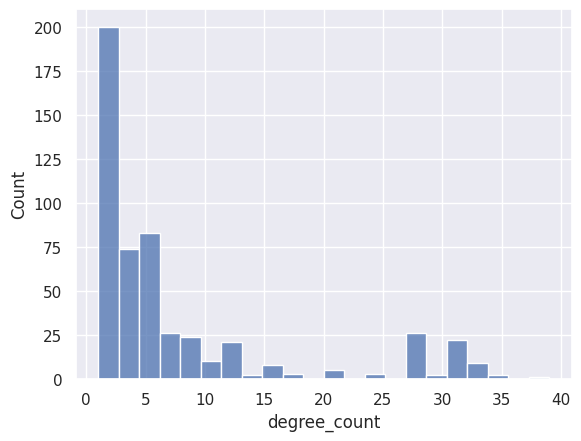

In [108]:
sns.histplot(data['degree_count'])

#### Dropping the outliers (colabs > 1000)

As we can see above there collaborators who are much higher than the collaborations, and much of them are bot's accounts (e.g *houndci* and *nrel-bot*). For this, we're removing them for the analysis.

In [109]:
selRows = data[data['colabs'] > 400].index
data = data.drop(selRows,axis=0)

### Normalizing focus

After removing the outliers we need to normalize the focus metric to properly give insights about the data.

In [110]:
x = data['focus']
x_norm = (x-np.min(x))/(np.max(x)-np.min(x)) + 1e-10 #For log issues in the next cells
data['focus'] = x_norm

In [111]:
data['degree'].describe().to_frame()

,degree
count,519.000000
mean,0.014740
std,0.018095
min,0.001923
25%,0.001923
50%,0.007692
75%,0.015385
max,0.075000


In [112]:
data['focus'].describe().to_frame()

,focus
count,5.190000e+02
mean,6.756622e-02
std,8.684014e-02
min,1.000000e-10
25%,2.614968e-02
50%,4.238052e-02
75%,7.614646e-02
max,1.000000e+00


### Regression 

<AxesSubplot: xlabel='focus', ylabel='Count'>

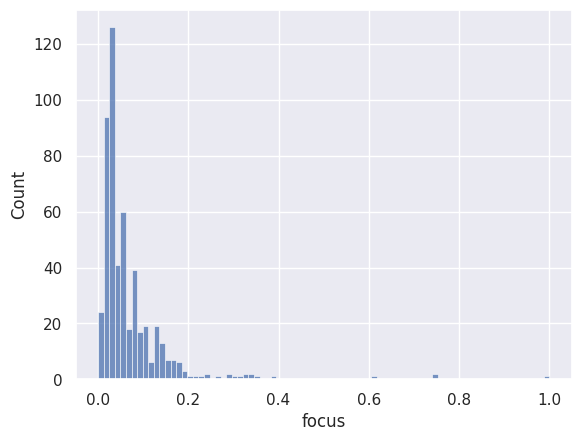

In [113]:
sns.histplot(data['focus'])

<AxesSubplot: xlabel='degree', ylabel='Count'>

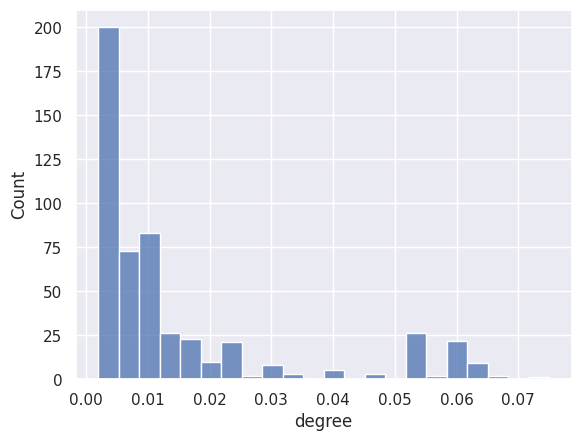

In [114]:
sns.histplot(data['degree'])

In [115]:
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

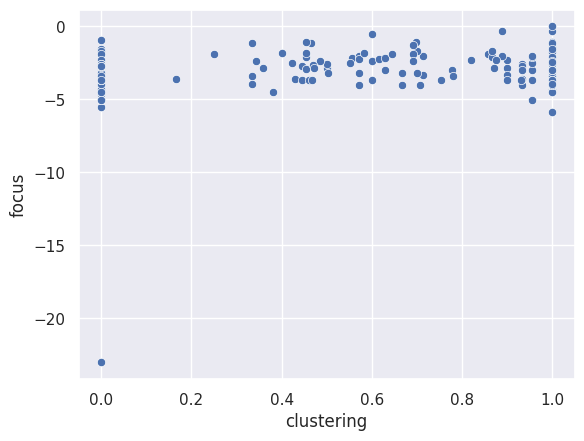

In [116]:
sns.scatterplot(x=data['clustering'], y=np.log(data['focus']));

In [117]:
data.sort_values(by="focus",ascending=False)

,focus,colabs,clustering,degree,degree_count
id,,,,,
kaplun,1.000000e+00,126,1.000000,0.013462,7
boegel,7.484220e-01,95,1.000000,0.005769,3
stvstnfrd,7.484220e-01,95,0.889483,0.065385,34
bartvm,6.113294e-01,81,0.600000,0.011538,6
jeromekelleher,3.832281e-01,50,0.000000,0.001923,1
...,...,...,...,...,...
bgruening,6.440809e-03,5,0.000000,0.001923,1
MCGallaspy,4.016723e-03,6,0.000000,0.001923,1
f0k,2.817854e-03,5,1.000000,0.009615,5


### Residuals

In [118]:
result = reg.linear(data=data, formula='focus ~ clustering')

In [119]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  focus   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.645
Date:                Thu, 08 Jun 2023   Prob (F-statistic):              0.105
Time:                        19:51:35   Log-Likelihood:                 533.67
No. Observations:                 519   AIC:                            -1063.
Df Residuals:                     517   BIC:                            -1055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0578      0.007      8.117      0.000       0.044       0.072
clustering     0.0143      0.009      1.626      0.105      -0.003       0.032
==============================================================================
Omnibus:                      592.150   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40529.683
Skew:                           5.354   Prob(JB):                         0.00
Kurtosis:                      44.947   Cond. No.                         3.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,0.014288,0.008786,0.104507


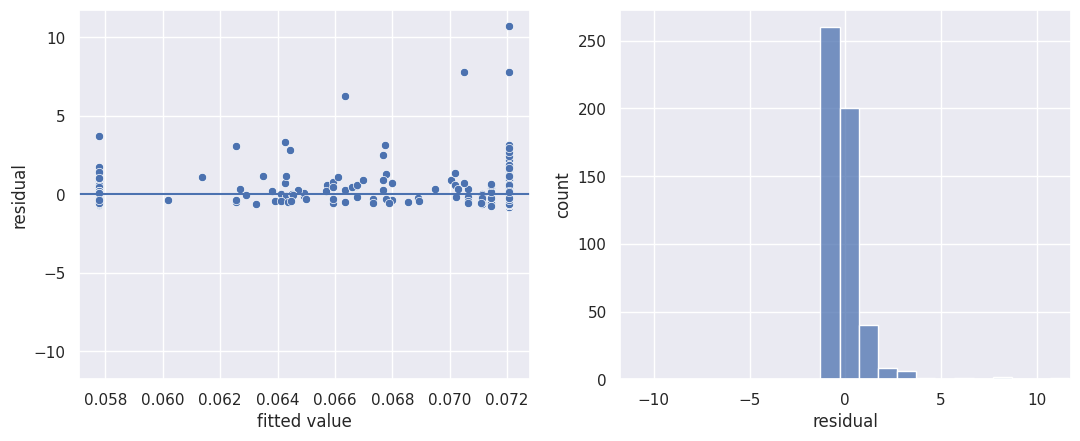

In [121]:
result.plot_residuals()

#### "Massaging" the data

As we can see, the distribution of residuals is not good as we want, because the residuals has not a randomic and normal distribution to give the give the necessary confidence to the model. 

Because of this, we can apply a logaritmic scale to the focus to get a better shape and use the degree as control variable (which means the quantity of neighbors of the vertex).

In [122]:
result = reg.linear(data=data, formula='np.log(focus) ~ clustering + degree')

In [123]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(focus)   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     5.147
Date:                Thu, 08 Jun 2023   Prob (F-statistic):            0.00612
Time:                        19:51:36   Log-Likelihood:                -837.19
No. Observations:                 519   AIC:                             1680.
Df Residuals:                     516   BIC:                             1693.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3841      0.101    -33.561      0.000      -3.582      -3.186
clustering     0.2229      0.133      1.677      0.094      -0.038       0.484
degree         6.0997      3.186      1.914      0.056      -0.160      12.359
==============================================================================
Omnibus:                      786.801   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           371342.134
Skew:                          -8.035   Prob(JB):                         0.00
Kurtosis:                     133.052   Cond. No.                         73.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,0.222930,0.132973,0.094244
degree,6.099706,3.186241,0.056123


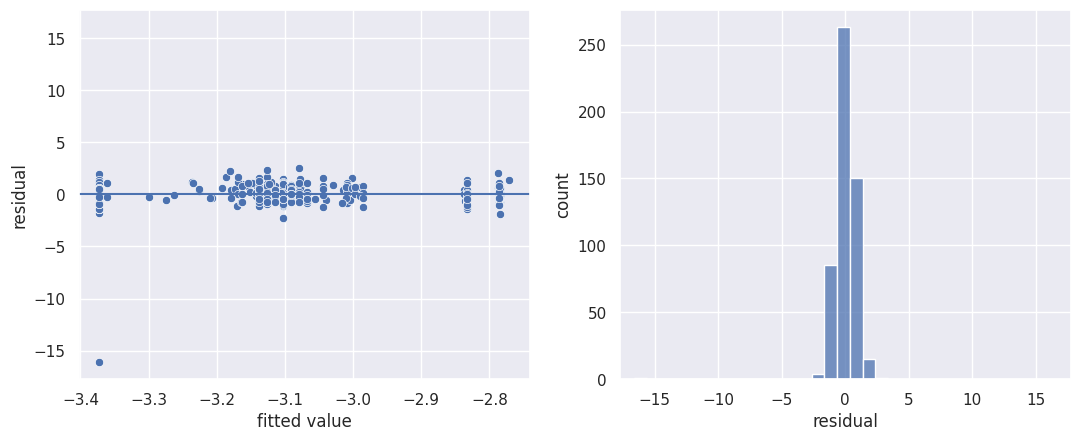

In [125]:
result.plot_residuals()

## Saving the graph

In [83]:
import netpixi

In [84]:
gt_save(g, '../networks/colabs_python.net.gz')